# 💳 Credit Card Fraud Detection Intuitions

## What is Credit Card Fraud?
Credit card fraud is when someone uses another person's credit card or account information to make unauthorized purchases or access funds through cash advances. Credit card fraud doesn’t just happen online; it happens in brick-and-mortar stores, too. As a business owner, you can avoid serious headaches – and unwanted publicity – by recognizing potentially fraudulent use of credit cards in your payment environment.

## Three challenges surrounding credit card fraud

1. It's not always easy to agree on ground truth for what "fraud" means.
2. Regardless of how you define ground truth, the vast majority of charges are not fraudulent.
3. Most merchants aren't experts at evaluating the business impact of fraud.

## Problem Statement:

The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be a fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.


## Observations
- Very few transactions are actually fraudulent (less than 1%). The data set is highly skewed, consisting of `492` frauds in a total of `284,807` observations. This resulted in only `0.172%` fraud cases. This skewed set is justified by the low number of fraudulent transactions.
- The dataset consists of numerical values from the `28` ‘Principal Component Analysis (PCA)’ transformed features, namely V1 to V28. Furthermore, there is no metadata about the original features provided, so pre-analysis or feature study could not be done.
- The ‘Time’ and ‘Amount’ features are not transformed data.
- There is no missing value in the dataset.

## Why does class imbalanced affect model performance?

- In general, we want to maximize the recall while capping FPR (False Positive Rate), but you can classify a lot of charges wrong and still maintain a low FPR because you have a large number of true negatives.
- This is conducive to picking a relatively low threshold, which results in the high recall but extremely low precision.

## What is the catch?
- Training a model on a balanced dataset optimizes performance on validation data.
- However, the goal is to optimize performance on the imbalanced production dataset. You ultimately need to find a balance that works best in production.
- One solution to this problem is: Use all fraudulent transactions, but subsample non-fraudulent transactions as needed to hit our target rate.

## Business questions to brainstorm:
Since all features are anonymous, we will focus our analysis on non-anonymized features: `Time`, `Amount`
1. How different is the amount of money used in different transaction classes?
2. Do fraudulent transactions occur more often during a certain frames?


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [3]:
data = pd.read_csv("credit_card_fraud.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 🔍 Exploratory Data Analysis


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Let us now check the missing values in the dataset

In [6]:
data.isnull().sum().sum()

0

In [7]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### The only non-transformed variables to work with are:
- `Time`
- `Amount`
- `Class` (1: fraud, 0: not_fraud)

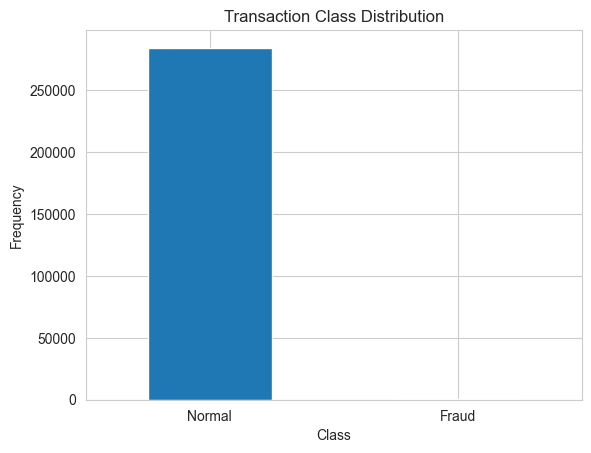

In [8]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [9]:
data.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Determine the number of fraud and valid transactions in the entire dataset.

In [10]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

print(f"Shape of Fraudulant transactions: {fraud.shape}")
print(f"Shape of Non-Fraudulant transactions: {normal.shape}")

Shape of Fraudulant transactions: (492, 31)
Shape of Non-Fraudulant transactions: (284315, 31)


How different are the amount of money used in different transaction classes?

In [11]:
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

,Amount,Amount
count,492.00,284315.00
mean,122.21,88.29
std,256.68,250.11
min,0.00,0.00
25%,1.00,5.65
50%,9.25,22.00
75%,105.89,77.05
max,2125.87,25691.16


Do fraudulent transactions occur more often during certain time frame ?

In [12]:
pd.concat([fraud.Time.describe(), normal.Time.describe()], axis=1)

,Time,Time
count,492.00,284315.00
mean,80746.81,94838.20
std,47835.37,47484.02
min,406.00,0.00
25%,41241.50,54230.00
50%,75568.50,84711.00
75%,128483.00,139333.00
max,170348.00,172792.00


/Users/dinghuan/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/xh/g_8wwrg5283fzpv719jgnrcc0000gn/T/ipykernel_18590/3161143837.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 2)
/Users/dinghuan/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


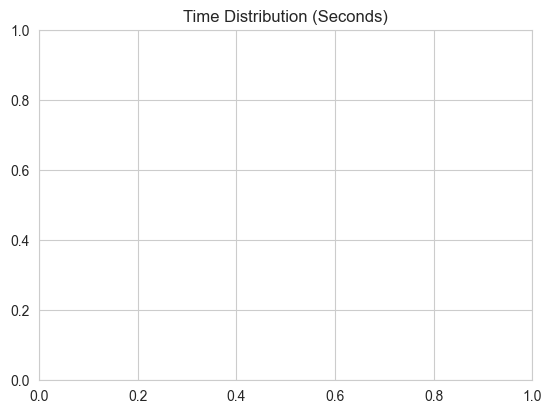

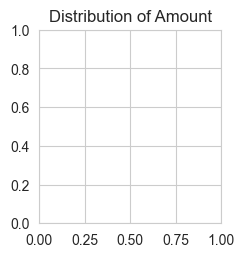

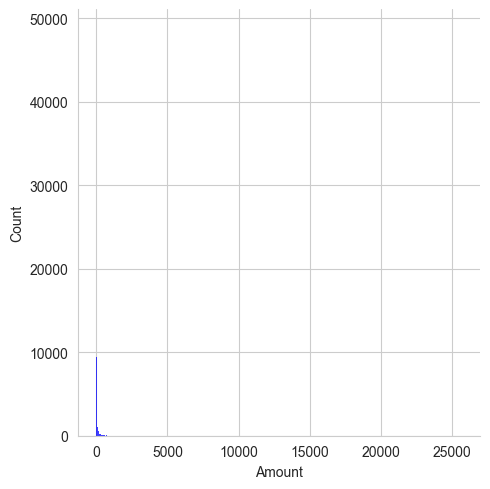

In [13]:
# plot the time feature
plt.figure(figsize=(14,10))

plt.subplot(2, 2, 1)
plt.title('Time Distribution (Seconds)')

sns.displot(data['Time'], color='blue');

#plot the amount feature
plt.subplot(2, 2, 2)
plt.title('Distribution of Amount')
sns.displot(data['Amount'],color='blue');

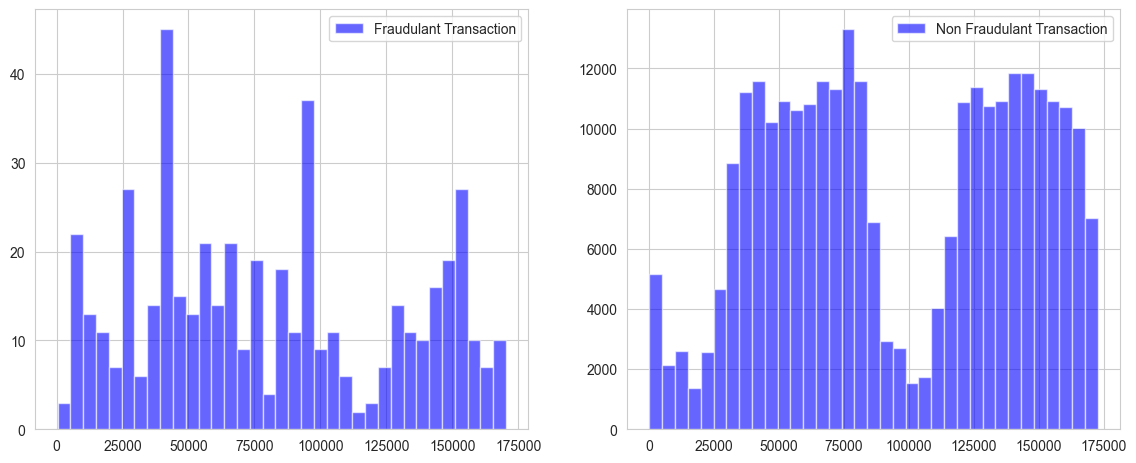

In [14]:
# data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6)
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()

By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

Doesn't seem like the time of transaction really matters here as per above observation.
Now let us take a sample of the dataset for out modelling and prediction

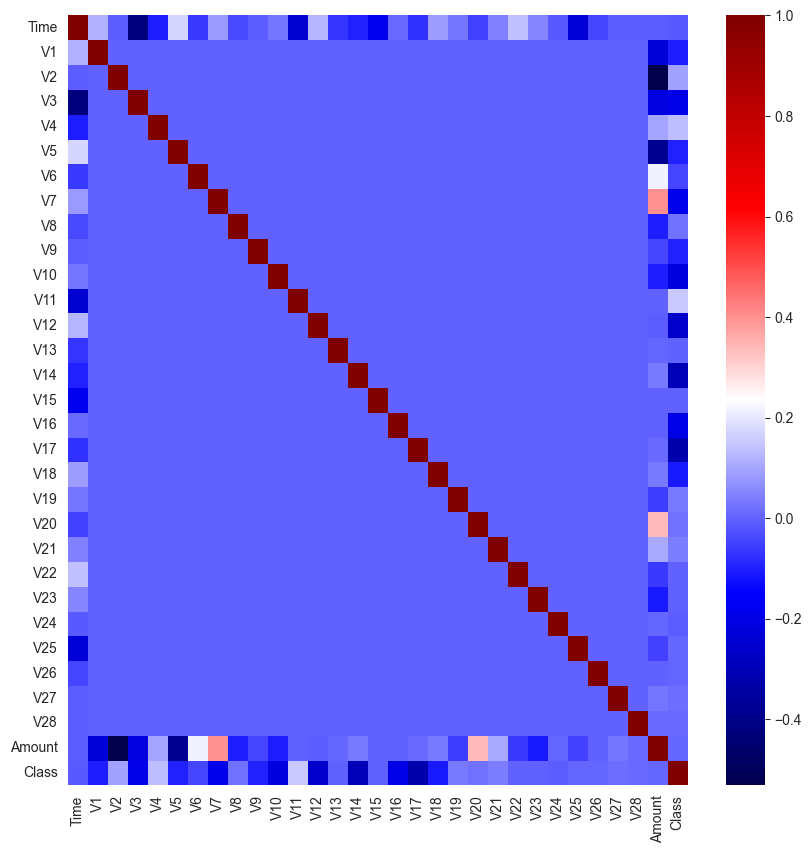

In [15]:
# heatmap to find any high correlations

plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(), cmap="seismic")
plt.show();

### Highest correlations come from:
    - Time & V3 (-0.42)
    - Amount & V2 (-0.53)
    - Amount & V4 (0.4)

- While these correlations are high, I don't expect it to run the risk of multicollinearity.

- The correlation matrix shows also that none of the V1 to V28 PCA components have any correlation to each other however if we observe Class has some form positive and negative correlations with the V components but has no correlation with Time and Amount.

# 3. Data Pre-processing

`Time` and `Amount` should be scaled as the other columns.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X = data.drop('Class', axis=1)
y = data.Class

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, 
                                                            test_size=0.2, random_state=42)

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

Fraudulant transaction weight: 0.0017994745785028623
Non-Fraudulant transaction weight: 0.9982005254214972


In [17]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'_'*55}")
print(f"VALIDATION: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n{'_'*50}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (159491, 30), y_train: (159491,)
_______________________________________________________
VALIDATION: X_validate: (39873, 30), y_validate: (39873,)
__________________________________________________
TESTING: X_test: (85443, 30), y_test: (85443,)


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

# 4. Model Building
# 4. 1. Artificial Neural Network (ANNs)

In [21]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    # keras.layers.Dense(256, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               7936      
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [27]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.00,-11.88,10.07,-9.83,-2.07,-5.36,-2.61,-4.92,7.31,1.91,...,0.21,0.11,1.01,-0.51,1.44,0.25,0.94,0.82,0.77,0
284803,172787.00,-0.73,-0.06,2.04,-0.74,0.87,1.06,0.02,0.29,0.58,...,0.21,0.92,0.01,-1.02,-0.61,-0.40,0.07,-0.05,24.79,0
284804,172788.00,1.92,-0.30,-3.25,-0.56,2.63,3.03,-0.30,0.71,0.43,...,0.23,0.58,-0.04,0.64,0.27,-0.09,0.00,-0.03,67.88,0
284805,172788.00,-0.24,0.53,0.70,0.69,-0.38,0.62,-0.69,0.68,0.39,...,0.27,0.80,-0.16,0.12,-0.57,0.55,0.11,0.10,10.00,0


In [26]:
METRICS = [
#     keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.h5')]
class_weight = {0:w_p, 1:w_n}

r = model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=2048, 
    epochs=300, 
#     class_weight=class_weight,
    callbacks=callbacks,
)

In [24]:
score = model.evaluate(X_test, y_test)
print(score)

2671/2671 [==============================] - 13s 4ms/step - loss: 0.0037 - fn: 27.0000 - fp: 11.0000 - tn: 85296.0000 - tp: 109.0000 - precision: 0.9083 - recall: 0.8015
[0.0037424720358103514, 27.0, 11.0, 85296.0, 109.0, 0.9083333611488342, 0.8014705777168274]


TypeError: 'NoneType' object is not subscriptable

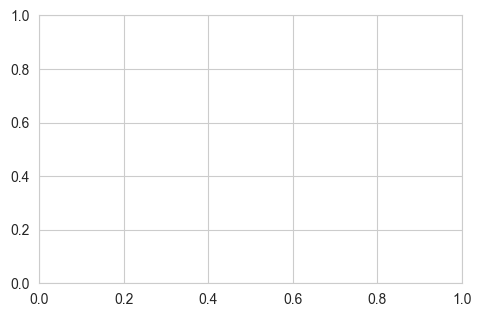

In [27]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['fn'], label='fn')
plt.plot(r.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend()

In [22]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

2671/2671 [==============================] - 7s 2ms/step
Train Result:
Accuracy Score: 99.99%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   0.93      1.00       0.97          1.00
f1-score       1.00   0.96      1.00       0.98          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159203      1]
 [    19    268]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.91      1.00       0.95          1.00
recall        1.00   0.80      1.00       0.90          1.00
f1-score      1.00   0.85      1.00       0.93          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_________

# 4. 2. XGBoost

In [29]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train, eval_metric='aucpr')

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['XGBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

/Users/dinghuan/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


NameError: name 'print_score' is not defined

# 4. 3. Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, oob_score=False)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['Random Forest'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   1.00      1.00       1.00          1.00
f1-score       1.00   1.00      1.00       1.00          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159204      0]
 [     1    286]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.92      1.00       0.96          1.00
recall        1.00   0.79      1.00       0.90          1.00
f1-score      1.00   0.85      1.00       0.93          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix:

NameError: name 'scores_dict' is not defined

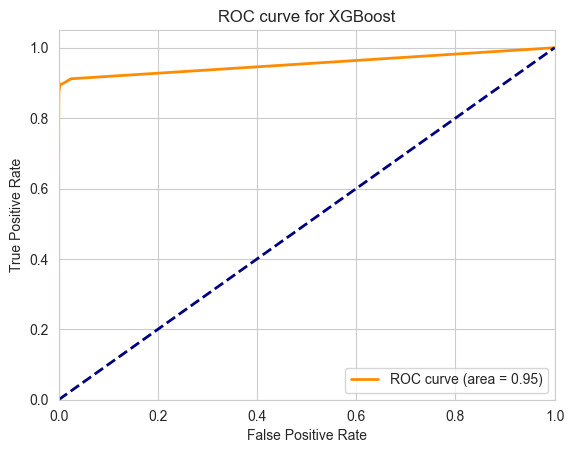

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

y_pred = rf_clf.predict(X_test)
y_pred_proba = rf_clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_proba[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for XGBoost")
plt.legend(loc="lower right")
plt.savefig('xgboost.pdf')
plt.show()


# 4. 4. CatBoost

In [38]:
from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier()
cb_clf.fit(X_train, y_train)

Learning rate set to 0.089847
0:	learn: 0.3914637	total: 114ms	remaining: 1m 53s
1:	learn: 0.2368418	total: 162ms	remaining: 1m 20s
2:	learn: 0.1341780	total: 223ms	remaining: 1m 13s
3:	learn: 0.0788514	total: 284ms	remaining: 1m 10s
4:	learn: 0.0482949	total: 337ms	remaining: 1m 7s
5:	learn: 0.0315326	total: 385ms	remaining: 1m 3s
6:	learn: 0.0213628	total: 439ms	remaining: 1m 2s
7:	learn: 0.0153604	total: 526ms	remaining: 1m 5s
8:	learn: 0.0115137	total: 572ms	remaining: 1m 2s
9:	learn: 0.0090128	total: 627ms	remaining: 1m 2s
10:	learn: 0.0071550	total: 681ms	remaining: 1m 1s
11:	learn: 0.0060638	total: 739ms	remaining: 1m
12:	learn: 0.0052453	total: 787ms	remaining: 59.8s
13:	learn: 0.0046542	total: 854ms	remaining: 1m
14:	learn: 0.0042229	total: 906ms	remaining: 59.5s
15:	learn: 0.0038780	total: 964ms	remaining: 59.3s
16:	learn: 0.0036112	total: 1.02s	remaining: 58.9s
17:	learn: 0.0034152	total: 1.11s	remaining: 1m
18:	learn: 0.0032511	total: 1.16s	remaining: 59.8s
19:	learn: 0.003

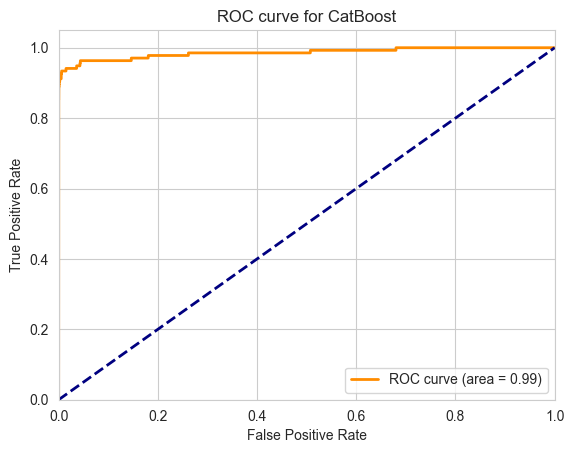

In [39]:
y_pred = cb_clf.predict(X_test)
y_pred_proba = cb_clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_proba[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for CatBoost")
plt.legend(loc="lower right")
plt.savefig('catboost.pdf')
plt.show()

In [27]:
y_train_pred = cb_clf.predict(X_train)
y_test_pred = cb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['CatBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   1.00      1.00       1.00          1.00
f1-score       1.00   1.00      1.00       1.00          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159204      0]
 [     1    286]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.93      1.00       0.97          1.00
recall        1.00   0.82      1.00       0.91          1.00
f1-score      1.00   0.87      1.00       0.94          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix:

# 4. 5. LigthGBM

In [5]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

y_train_pred = lgbm_clf.predict(X_train)
y_test_pred = lgbm_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['LigthGBM'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

NameError: name 'X_train' is not defined

In [4]:
import lightgbm 

# 5. Model Comparaison

<AxesSubplot:>

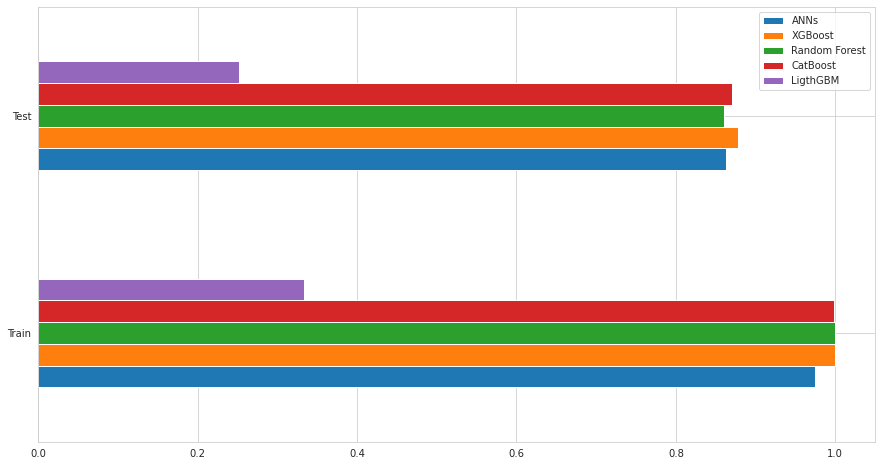

In [ ]:
scores_df = pd.DataFrame(scores_dict)

scores_df.plot(kind='barh', figsize=(15, 8))